# Models

Group project for the 2019 Data Science Workshop at the University of California, Berkeley.

The project is the Google Analytics Customer Revenue Prediction competition on Kaggle: https://www.kaggle.com/c/ga-customer-revenue-prediction

Group members:

* Andy Vargas (mentor)
* Yuem Park
* Marvin Pohl
* Michael Yeh

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

pd.options.display.max_columns = 999

In [2]:
data = pd.read_csv('./data/train_df_yp.csv', dtype={'fullVisitorId':'str'})
print('number of visitors: {}'.format(len(data)))
print('number of features: {}'.format(len(data.columns) - 3))

number of visitors: 329636
number of features: 66


In [3]:
data.columns

Index(['fullVisitorId', 'channelGrouping.(Other)',
       'channelGrouping.Affiliates', 'channelGrouping.Direct',
       'channelGrouping.Display', 'channelGrouping.Organic Search',
       'channelGrouping.Paid Search', 'channelGrouping.Referral',
       'channelGrouping.Social', 'device.browser.Android Webview',
       'device.browser.Chrome', 'device.browser.Edge',
       'device.browser.Firefox', 'device.browser.Internet Explorer',
       'device.browser.OTHER', 'device.browser.Opera Mini',
       'device.browser.Safari', 'device.browser.Safari (in-app)',
       'device.browser.Samsung Internet', 'device.operatingSystem.(not set)',
       'device.operatingSystem.Android', 'device.operatingSystem.Chrome OS',
       'device.operatingSystem.Linux', 'device.operatingSystem.Macintosh',
       'device.operatingSystem.OTHER', 'device.operatingSystem.Windows',
       'device.operatingSystem.iOS', 'geoNetwork.subContinent.Eastern Asia',
       'geoNetwork.subContinent.Northern America',
    

## Feature Selection

Add a column for DNR, RZR, RPR:

In [4]:
data.loc[data['return_flag']==0, 'stratify_flag'] = 'DNR'
data.loc[(data['return_flag']==1) & (data['total_predict_revenue']==0), 'stratify_flag'] = 'RZR'
data.loc[(data['return_flag']==1) & (data['total_predict_revenue']!=0), 'stratify_flag'] = 'RPR'

In [5]:
print(len(data[data['stratify_flag']=='RPR']))

109


Pull out only these rows:

In [6]:
data_RPR = data[data['stratify_flag']=='RPR'].copy()
data_RPR.reset_index(drop=True, inplace=True)

Since we only have 109 data points, let's minimize the number of features that we use:

In [7]:
training_cols = []
for col in data_RPR.columns:
    if 'trafficSource.medium.' not in col:
        training_cols.append(col)
        
data_RPR = data_RPR[training_cols]

print('number of features: {}'.format(len(data_RPR.columns) - 4))

number of features: 59


In [8]:
X_cols = []
for col in data_RPR.columns:
    if (col!='total_predict_revenue') and (col!='return_flag') and (col!='stratify_flag') and (col!='fullVisitorId'):
        X_cols.append(col)
    
Y_cols = ['total_predict_revenue']

X = data_RPR[X_cols]
Y = data_RPR[Y_cols]

## Baseline

In [9]:
def get_RMSE(Y, Y_prediction):
    RMSE = mean_squared_error(np.log(Y), np.log(Y_prediction))
    return RMSE

Just predict the mean, and see what the RMSE is:

In [10]:
Y_baseline = np.ones(len(Y)) * np.mean(Y.values)

RMSE_baseline = get_RMSE(Y, Y_baseline)

print('baseline RMSE = {:.6f}'.format(RMSE_baseline))

baseline RMSE = 2.336166


## Random Forest Regressor

In [15]:
#####################################
# set the number of loops to run here, along with the number of samples to bootstrap each loop
n_loops = 100
n_samples = 75
#####################################

#####################################
# set the hyperparameter tuning space here
max_depth_HPT = np.arange(2, 22, 2)
max_features_HPT = np.arange(5, 55, 5)
#####################################

index = np.arange(len(X))

# set up mean and std RMSE storage arrays
RMSE_mean_train_HPT = np.zeros((len(max_depth_HPT), len(max_features_HPT)))
RMSE_std_train_HPT = np.zeros((len(max_depth_HPT), len(max_features_HPT)))

RMSE_mean_test_HPT = np.zeros((len(max_depth_HPT), len(max_features_HPT)))
RMSE_std_test_HPT = np.zeros((len(max_depth_HPT), len(max_features_HPT)))

# seed the RNG
np.random.seed(2019)

# loop over the hyperparameter space
for i in tqdm_notebook(range(len(max_depth_HPT)), desc='max_depth'):
    for j in tqdm_notebook(range(len(max_features_HPT)), desc='max_features', leave=False):

        RMSEs_train = np.zeros(n_loops)
        RMSEs_test = np.zeros(n_loops)

        # loop over the bootstrapping
        for k in tqdm_notebook(range(n_loops), desc='bootstrap', leave=False):

            # take a sample
            index_slice = resample(index, replace=False, n_samples=n_samples)

            # extract X and Y
            X_train = X.loc[index_slice]
            Y_train = Y.loc[index_slice]
            
            X_test = X.loc[~X.index.isin(index_slice)]
            Y_test = Y.loc[~Y.index.isin(index_slice)]

            # set up the RFR
            RFR = RandomForestRegressor(max_depth=max_depth_HPT[i],
                                        max_features=max_depth_HPT[j],
                                        n_estimators=50,bootstrap=True,criterion='mse')

            # fit
            RFR.fit(X_train, Y_train.values.ravel())

            # predict
            Y_train_prediction = RFR.predict(X_train)
            Y_test_prediction = RFR.predict(X_test)

            # calculate RMSE
            RMSE_train = get_RMSE(Y_train, Y_train_prediction)
            RMSE_test = get_RMSE(Y_test, Y_test_prediction)

            # store
            RMSEs_train[k] = RMSE_train
            RMSEs_test[k] = RMSE_test
            
        # store averages
        RMSE_mean_train_HPT[i,j] = np.mean(RMSEs_train)
        RMSE_std_train_HPT[i,j] = np.std(RMSEs_train)
        
        RMSE_mean_test_HPT[i,j] = np.mean(RMSEs_test)
        RMSE_std_test_HPT[i,j] = np.std(RMSEs_test)

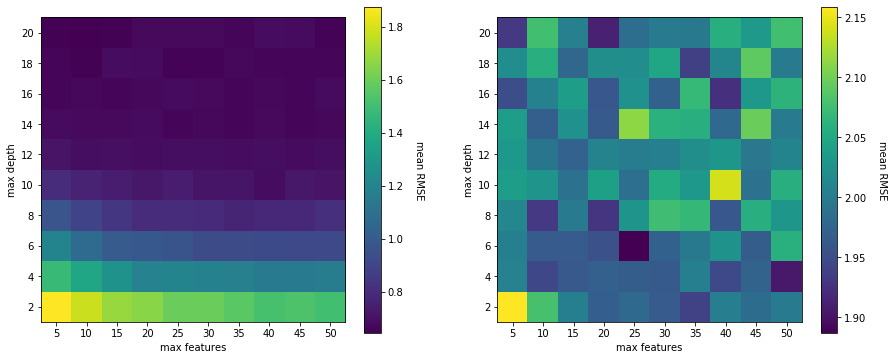

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))


im0 = ax[0].imshow(RMSE_mean_train_HPT, origin='lower')
im1 = ax[1].imshow(RMSE_mean_test_HPT, origin='lower')

cbar0 = fig.colorbar(im0, ax=ax[0])
cbar0.ax.set_ylabel('mean RMSE', rotation=-90, labelpad=20)

cbar1 = fig.colorbar(im1, ax=ax[1])
cbar1.ax.set_ylabel('mean RMSE', rotation=-90, labelpad=20)

for i in range(2):
    ax[i].set_xticks(np.arange(len(max_features_HPT)))
    ax[i].set_xticklabels(max_features_HPT)
    ax[i].set_xlabel('max features')

    ax[i].set_yticks(np.arange(len(max_depth_HPT)))
    ax[i].set_yticklabels(max_depth_HPT)
    ax[i].set_ylabel('max depth')

plt.show(fig)